# CZĘŚĆ 1 - OPTYMALIZACJA

## OPIS ZESTAWU DANYCH
Dane składają się z informacji o przylotach i odlotach wszystkich lotów komercyjnych w USA od października 1987 do kwietnia 2008 – przede wszystkim o ich opóźnieniach. \
Zbiór danych jest bardzo duży (120mln rekordów, 12GB danych) – na potrzeby projektu wykorzystamy jedynie dane z roku 2007 co ograniczy rozmiar przetwarzanych danych.

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import statistics
from sklearn.impute import KNNImputer
import seaborn as sns
import glob
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import isnull, when, count, col, hour, mean, lit, stddev,abs

#### OPIS KLAS
W sumie klas jest 29, opisują one następujące informacje:
* rok
* miesiąc
* dzień miesiąca
* dzień tygodnia
* rzeczywisty czas odlotu
* zaplanowany czas odlotu
* rzeczywisty czas przylotu
* zaplanowany czas przylotu
* kod przewoźnika
* numer lotu
* numer ogonowy samolotu
* całkowity czas lotu w minutach
* rzeczywisty czas lotu
* całkowity czas w powietrzu
* opóźnienie lotu w minutach
* miejsce startu
* miejsce docelowe
* odległość w milach
* dane dotyczące przyjazdu taksówki
* informacje o tym czy lot był anulowany
* powód anulowania (pogoda, przewoźnik, ochrona, NAS)
* przekierowanie (tak/nie)
* opóźnienie przewoźnika w minutach
* opóźnienie pogodowe w minutach
* opóźnienie NAS w minutach
* opóźnienie z powodów bezpieczeństwa w minutach
* sumaryczne opóźnienie w minutach

Celem projektu jest klasyfikacja tego, czy lot został odwołany - zmienna objaśniana - na podstawie podzbioru pozostałych kolumn (zmiennych objaśniających), które wybierzemy na podstawie dalszej analizy.

In [3]:
import zipfile
zf = zipfile.ZipFile("./data_mow.zip")
namelist = zf.namelist()[1:]
dfs = [pd.read_csv(zf.open(f)) for f in namelist]
data = pd.concat(dfs, ignore_index = True)
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data.head())

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743.00,745,1024.00,1018,US,343,N657AW,281.00,273.00,223.00,6.00,-2.00,ATL,PHX,1587,45.00,13.00,0,NaN,0,0.00,0.00,0.00,0.00,0.00
1,2006,1,11,3,1053.00,1053,1313.00,1318,US,613,N834AW,260.00,265.00,214.00,-5.00,0.00,ATL,PHX,1587,27.00,19.00,0,NaN,0,0.00,0.00,0.00,0.00,0.00
2,2006,1,11,3,1915.00,1915,2110.00,2133,US,617,N605AW,235.00,258.00,220.00,-23.00,0.00,ATL,PHX,1587,4.00,11.00,0,NaN,0,0.00,0.00,0.00,0.00,0.00
3,2006,1,11,3,1753.00,1755,1925.00,1933,US,300,N312AW,152.00,158.00,126.00,-8.00,-2.00,AUS,PHX,872,16.00,10.00,0,NaN,0,0.00,0.00,0.00,0.00,0.00
4,2006,1,11,3,824.00,832,1015.00,1015,US,765,N309AW,171.00,163.00,132.00,0.00,-8.00,AUS,PHX,872,27.00,12.00,0,NaN,0,0.00,0.00,0.00,0.00,0.00


Jak widać w powyższej próbce danych kolumny DepTime, CRSDepTime, ArrTime oraz CRSArrTime wymagają przetworzenia z formatu godzina * 100 + minuty do postaci zmiennych ciągłych.

In [4]:
for column in ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']:
    data[column] = data[column] // 100 + (data[column] % 100) / 60

  Jak widać w powyższej tabeli, niektóre kolumny zawierają dane tekstowe - UniqueCarrier, TailNum, Origin, Dest i CancellationCode. \
Z racji tego, że w projekcie chcielibyśmy się skupić na powiązaniach między odwołaniami lotów, a momentem ich odbywania, część danych będzie nam zbędna. Dlatego też zdecydowaliśmy się na usunięcie kolumn:
- UniqueCarrier - indywidualny kod przewoźnika
- TailNum - numer ogonowy
- Origin - miejsce rozpoczęcia podróży
- Dest - cel podróży
- CancellationCode - kod odwołania

Ponadto usuwamy także poniższe kolumny:
- FlightNum - ponieważ pełni on rolę numeru ID, więc nie będzie miało większego sensu uwzględnianie go w modelu.
- TaxiIn, TaxiOut - ponieważ dane na temat taksówki naszym zdaniem nie mają wpływu na opóźnienie/odwołanie lotu.

In [5]:
data.drop('UniqueCarrier', inplace=True, axis =1)
data.drop('TailNum', inplace=True, axis =1)
data.drop('Origin', inplace=True, axis =1)
data.drop('Dest', inplace=True, axis =1)
data.drop('CancellationCode', inplace=True, axis =1)
data.drop('FlightNum', inplace=True, axis =1)
data.drop('TaxiIn', inplace=True, axis =1)
data.drop('TaxiOut', inplace=True, axis =1)

In [6]:
with pd.option_context('display.float_format', '{:.2f}'.format, 'display.max_rows', None, 'display.max_columns', None):
    display(data.describe())

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,16984354.00,16984354.00,16984354.00,16984354.00,16637230.00,16984354.00,16598211.00,16984354.00,16598211.00,16982949.00,16598211.00,16598211.00,16637230.00,16984354.00,16984354.00,16984354.00,15179720.00,15179720.00,15179720.00,15179720.00,15179720.00
mean,2006.72,5.97,15.72,3.94,13.60,13.49,15.04,15.15,126.53,127.52,103.15,9.57,10.85,724.14,0.02,0.00,4.10,0.81,4.17,0.03,5.44
std,0.69,3.50,8.78,1.99,4.78,4.65,5.05,4.81,71.12,70.22,71.75,38.23,35.11,566.78,0.14,0.05,21.14,9.68,16.88,1.21,21.80
min,2006.00,1.00,1.00,1.00,0.02,0.00,0.02,0.00,5.00,-1240.00,-1425.00,-592.00,-1200.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2006.00,3.00,8.00,2.00,9.50,9.50,11.15,11.25,75.00,77.00,55.00,-9.00,-4.00,318.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2007.00,6.00,16.00,4.00,13.48,13.40,15.25,15.33,108.00,110.00,85.00,-1.00,0.00,574.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2007.00,9.00,23.00,6.00,17.53,17.33,19.18,19.12,157.00,157.00,132.00,14.00,10.00,952.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2008.00,12.00,31.00,7.00,29.50,23.98,29.92,24.00,1879.00,1435.00,1958.00,2598.00,2601.00,4962.00,1.00,1.00,2580.00,1429.00,1392.00,392.00,1366.00


Zbiór danych składa się z około 17 mln rekordów. Jak widać w powyższej tabeli dane obejmują okres z lat 2006 - 2008 i są dość równo rozłożone w tym okresie (średni miesiąc to czerwiec a dzień miesiąca to około 15).

Średnia godzina rzeczywistego odlotu jest późniejsza niż średnia godzina planowanego odlotu, podobnie średnia godzina rzeczywistego przylotu jest późniejsza niż planowanego przylotu i niż godzina odlotu. Dodatkowo zakres zmiennych zawiera się między 0 a 24, co pokazuje, że dane w tych kolumnach powinny być poprawne. 
 
W przypadku kolumn ElapsedTime, AirTime, ArrDelay i DepDelay można zauważyć, że kolumny te zawierają wartości ujemne - wydaje się, że są to wartości błędne. Można również zauważyć, że kolumny te mają bardzo dużą różnicę między 75% danych a maksimum, co wskazuje na to, że zawierają również wartości odstające.

Podobnie z wartościami odstającymi zachowują się kolumny Delay - tutaj dane niezerowe stanowią mniej niż 25% danych.

Powodem tych obserwacji jest brak równowagi pomiędzy klasami zminnej Cancelled - jedynie około 2% lotów ze zbioru danych zostało odwołane.

## WIZUALIZACJA DANYCH

### BOXPLOTY

In [7]:
columns_for_visualisation = [column for column in data.columns if column != 'Year']

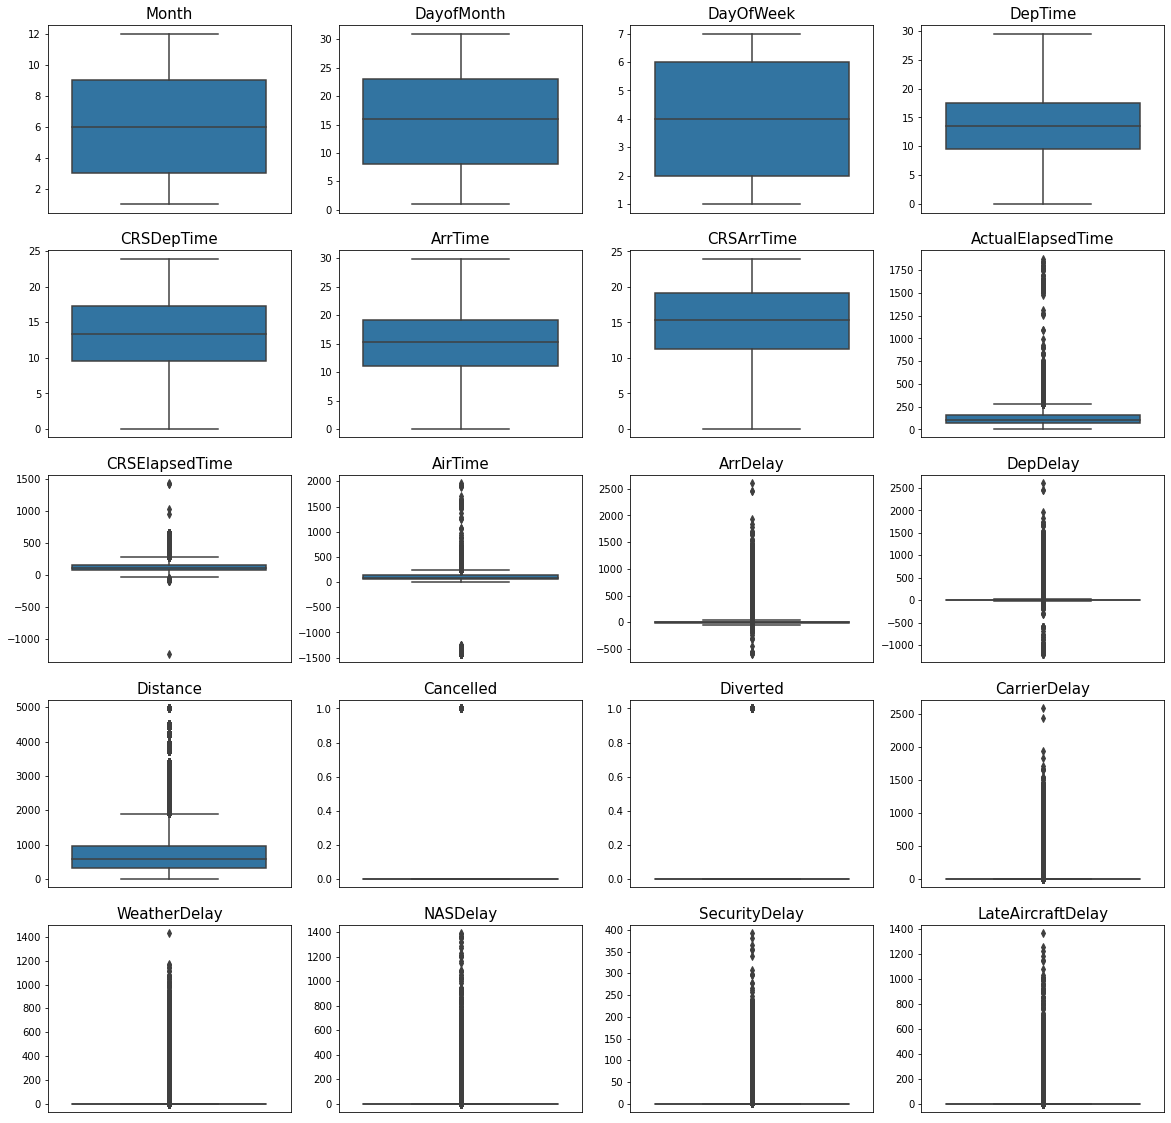

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
axes = axes.flatten()
for i, column in enumerate(columns_for_visualisation):
    sns.boxplot(data[column], ax=axes[i], orient='v')
    axes[i].set_title(column, fontsize=15)
    axes[i].set_ylabel('')
    axes[i].set_xticks([])
plt.show()

Na wykresach typu box plot można zauważyć, że zmienne określające datę odlotu (Month, DayOfMonth, DayOfWeek, DepTime, CRSDepTime, ArrTime) są mniej więcej po równo rozłożone - wąsy górne i dolne mają podobną długość, odległość mediany od górnego i dolnego kwartyla jest mniej więcej taka sama.

Natomiast zmienne określające rzeczywisty czas samolotu w powietrzu oraz opóźnienia, posiadają większość wartości odstających - co jest spowodowane faktem, że większość lotów w zbiorze to nie są loty odwołane ani opóźnione.

Można również zauważyć, że dane posiadają skrajnie różne zakresy - kolumny ElapsedTime, AirTime, ArrDelay, DepDelay czy Distance posiadają wartości w tysiącach, a kolumny Month, DayOfMonth, DayOfWeek, DepTime, CRSDepTime, ArrTime mają wartości w dziesiątkach - jest tu różnica dwóch rzędów wartości pomiedzy tymi zakresami.

### HISTOGRAMY

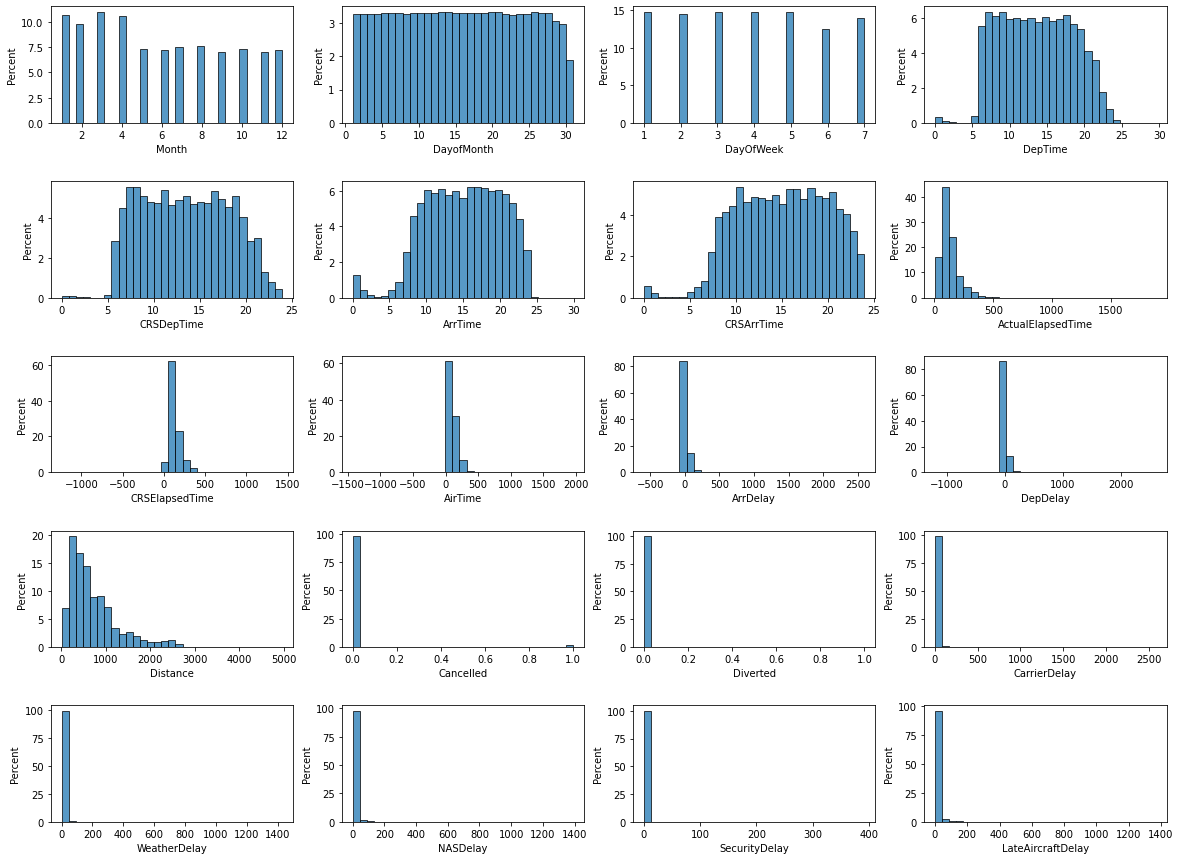

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
axes = axes.flatten()
for i, column in enumerate(columns_for_visualisation):
    sns.histplot(data, x=column, ax=axes[i], bins=31, stat="percent")
    fig.subplots_adjust(hspace=0.5)
plt.show()

In [10]:
data['Cancelled'].value_counts(normalize=True)

0    0.979562
1    0.020438
Name: Cancelled, dtype: float64

Rozkład danych w kolumnach Month, DayOfMonth i DayOfWeek jest mniej więcej równy. W przypadku miesięcy trochę więcej danych pochodzi z okresu od stycznia do kwietnia, w przypadku dni miesiąca mniej jest danych dla 29-31 dnia miesiąca (jest to spowodowane również nierówną długością miesięcy w ciągu roku). W przypadku dni tygodnia trochę mniej danych jest z soboty niż z innych dni tygodnia.

Dla daych dotyczących godzin można zauważyć, że większość odlotów ma miejsce pomiędzy godziną 6 a 18, natomiast przyloty zdarzają się częściej także po północy.

Dane dotyczące czasu w powietrzu oraz opóźnień są posiadają jeden widoczny pik oraz niewielkie wartości poza nim - jest to spowodowane tym, że są one określone głównie dla lotów opóźnionych i odwołanych, a większość danych takich nie jest.

Balans dla zmiennej przewidywanej czyli Cancelled jest taki, że loty nieodwołane stanowią prawie 98% danych. Z tego powodu przy klasyfikacji zastosujemy odpowiednie wagi, które skompensują tą różnicę.

#### TO DO: Dodać komentarz dotyczący histogramów

### PAIR PLOT

In [11]:
sample = data.sample(n=100, random_state=42)

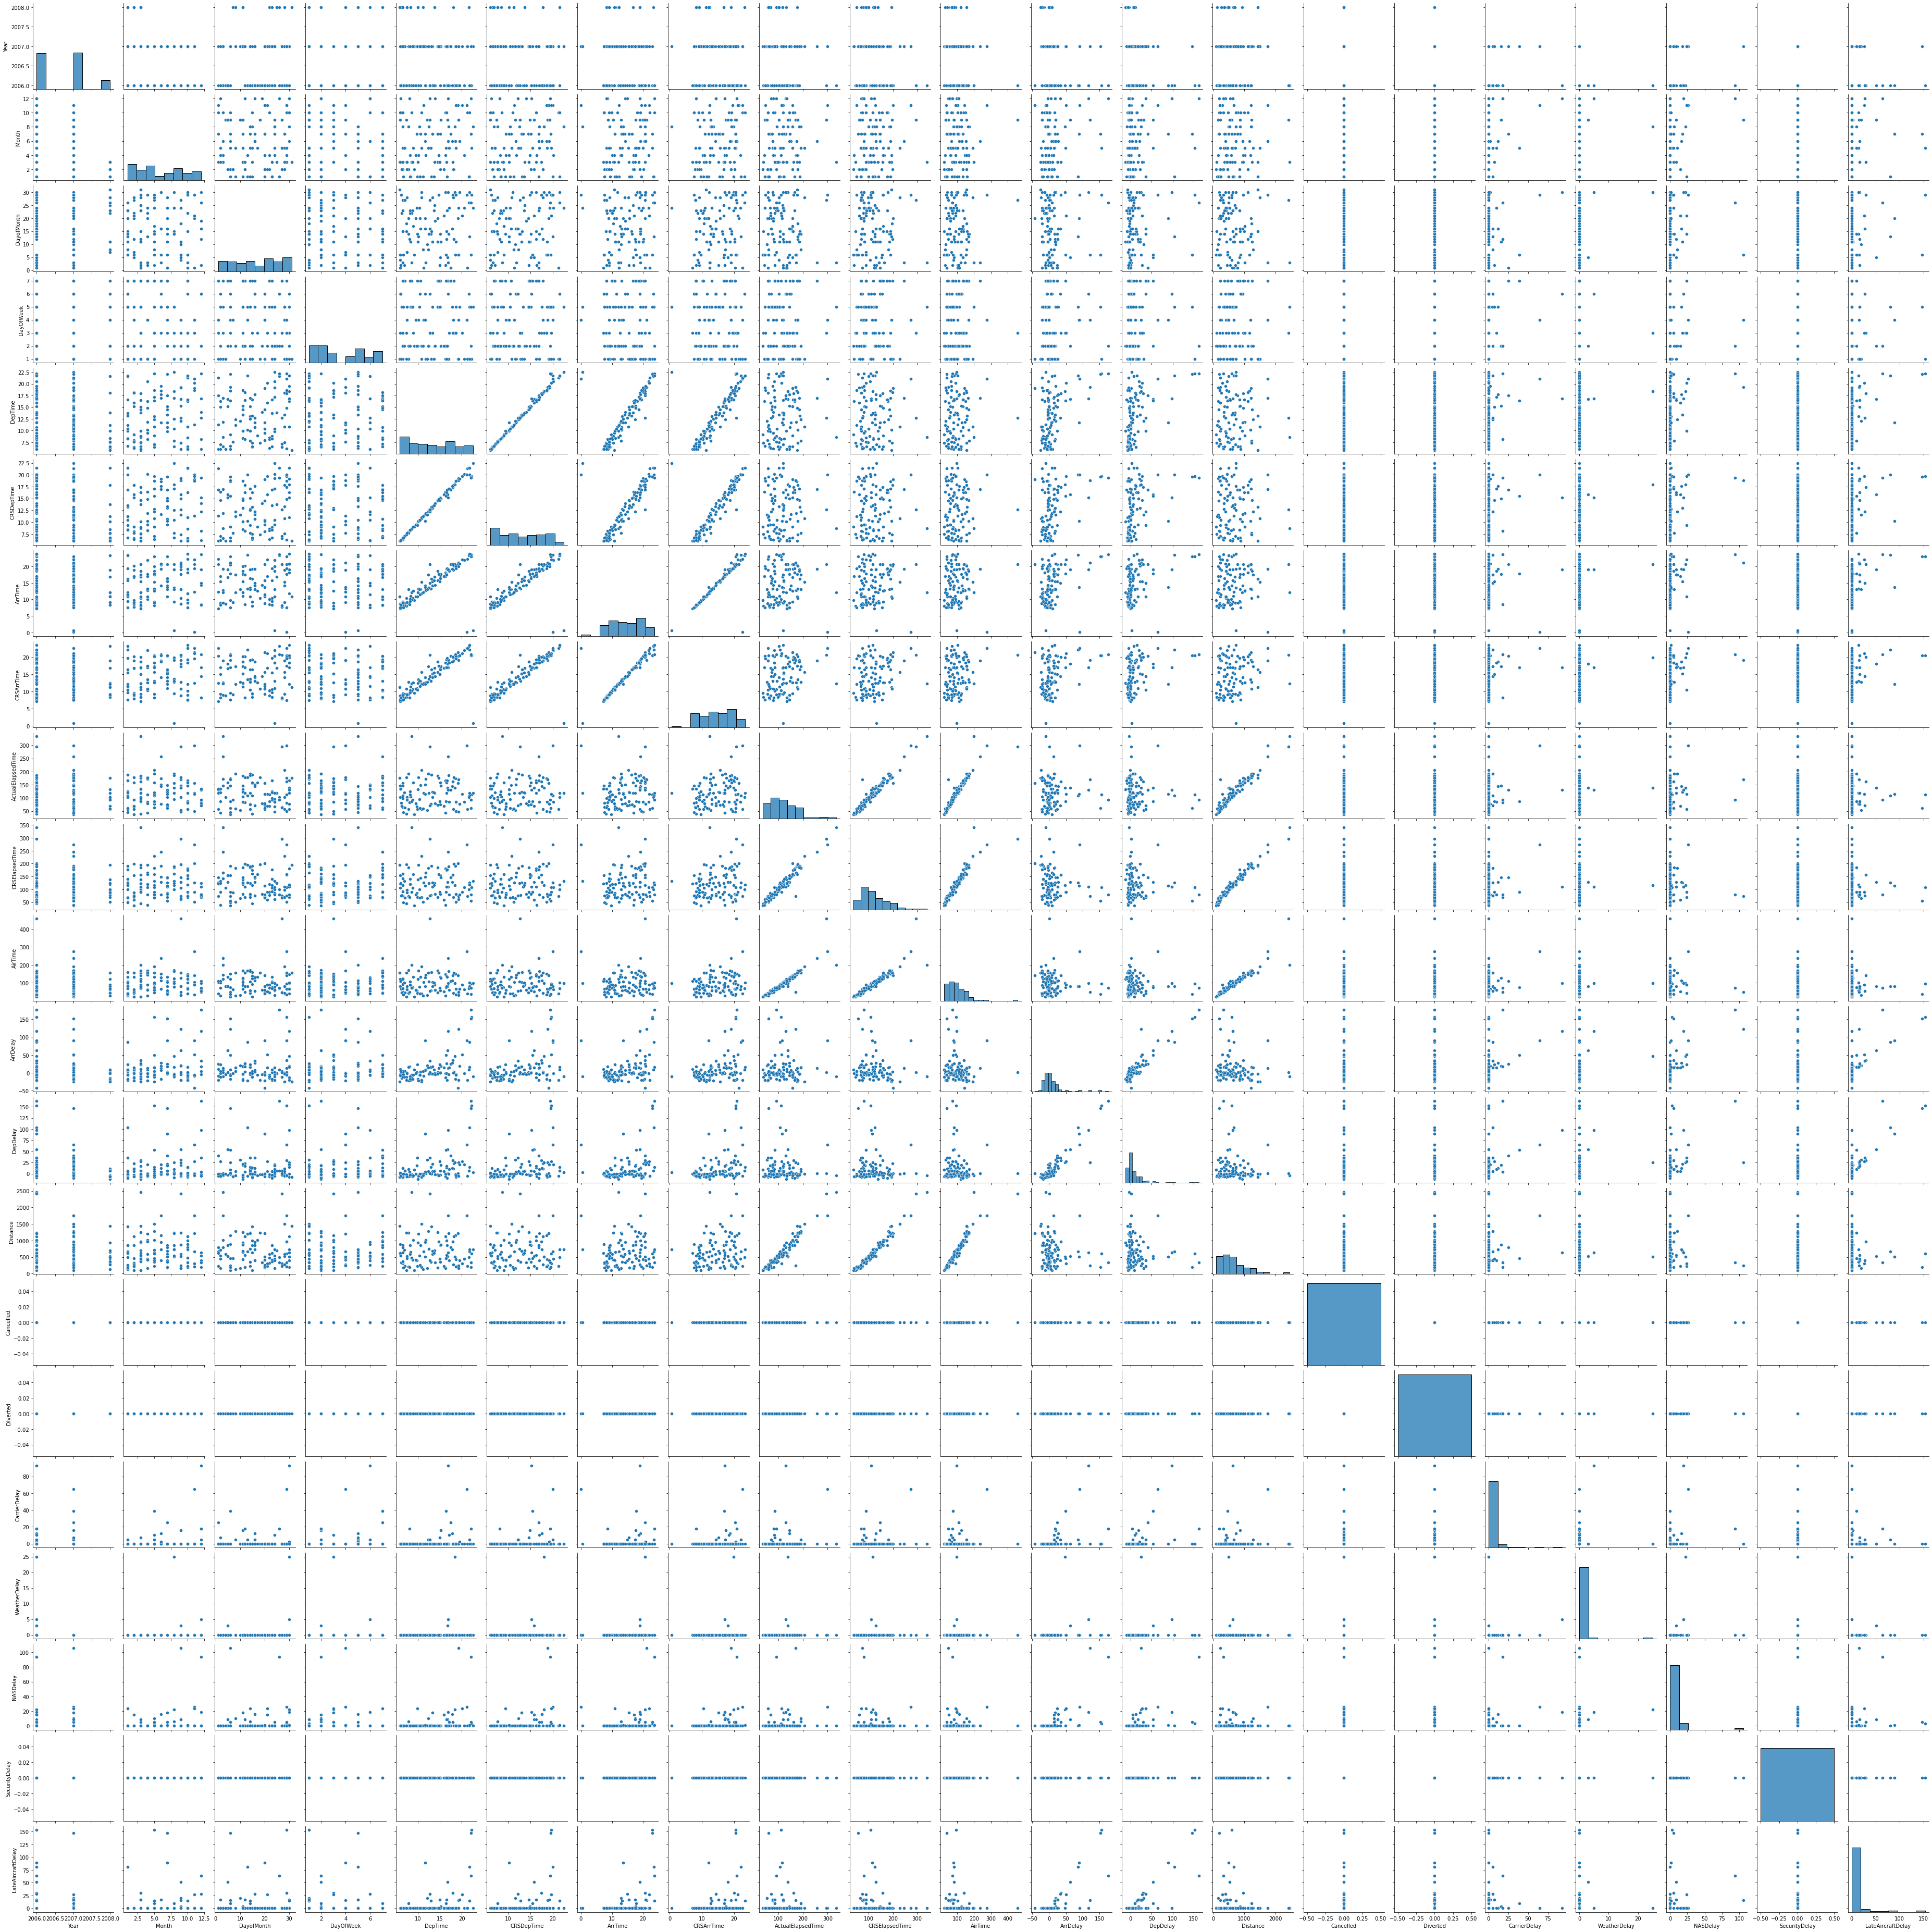

In [12]:
#scatter plot matrix
sns.pairplot(sample)

#### TO DO: Dodać komentarz dotyczący scatterplot

## PROBLEMY Z DANYMI - DANE BRAKUJĄCE, NIEPRAWIDŁOWE, ODSTAJĄCE

### SPRAWDZENIE POPRAWNOŚCI TYPÓW DANYCH

In [13]:
import pyarrow as pa

table = pa.Table.from_pandas(data)
print(table.schema)

Year: int64
Month: int64
DayofMonth: int64
DayOfWeek: int64
DepTime: double
CRSDepTime: double
ArrTime: double
CRSArrTime: double
ActualElapsedTime: double
CRSElapsedTime: double
AirTime: double
ArrDelay: double
DepDelay: double
Distance: int64
Cancelled: int64
Diverted: int64
CarrierDelay: double
WeatherDelay: double
NASDelay: double
SecurityDelay: double
LateAircraftDelay: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 2764


Jak widać wyżej - wszystkie dane występują w poprawnym formacie.

### NAPRAWA WIERSZY Z PUSTYMI DANYMI

In [14]:
# Obliczenie ilosci pustych danych
# Obliczenie ilosci pustych danych
np.sum(data.isna())

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               347124
CRSDepTime                 0
ArrTime               386143
CRSArrTime                 0
ActualElapsedTime     386143
CRSElapsedTime          1405
AirTime               386143
ArrDelay              386143
DepDelay              347124
Distance                   0
Cancelled                  0
Diverted                   0
CarrierDelay         1804634
WeatherDelay         1804634
NASDelay             1804634
SecurityDelay        1804634
LateAircraftDelay    1804634
dtype: int64

In [15]:
sizeBeforeDeleteNull= data.count()
dataWithoutNull = data.dropna()
sizeAfterDeleteNull =  dataWithoutNull.count()
print("Usunieto: ", sizeBeforeDeleteNull - sizeAfterDeleteNull)

print("Percent od reduced rows: ", 100*sum(sizeBeforeDeleteNull - sizeAfterDeleteNull)/sum(sizeBeforeDeleteNull))

Usunieto:  Year                 2120681
Month                2120681
DayofMonth           2120681
DayOfWeek            2120681
DepTime              1773557
CRSDepTime           2120681
ArrTime              1734538
CRSArrTime           2120681
ActualElapsedTime    1734538
CRSElapsedTime       2119276
AirTime              1734538
ArrDelay             1734538
DepDelay             1773557
Distance             2120681
Cancelled            2120681
Diverted             2120681
CarrierDelay          316047
WeatherDelay          316047
NASDelay              316047
SecurityDelay         316047
LateAircraftDelay     316047
dtype: int64
Percent od reduced rows:  9.632348481617129


In [16]:
### TO DO: ZMIENIC SPOSÓB RADZENIA SOBIE Z PUSTYMI DANYMI
### TO DO: Dodać komentarz dotyczący danych pustych

### USUWANIE DANYCH ODSTAJĄCYCH

In [17]:
sizeBefore = np.shape(data)[0]
for col in data.columns:
    data = data[np.abs(data[col]-data[col].mean()) <= (3*data[col].std())]
sizeAfter =  np.shape(data)[0]
print("Count of reduced rows: ", sizeBefore - sizeAfter)
print("Percent od reduced rows: ", 100*(sizeBefore - sizeAfter)/sizeBefore)

Count of reduced rows:  4950693
Percent od reduced rows:  29.148550483580358


#### TO DO: Dodać komentarz dotyczący danych odstających

# KORELACJE

In [18]:
# sns.pairplot(data)

In [19]:
# plt.figure(figsize=(20, 20), dpi=80)
# corrMatrix = data.corr()
# sns.heatmap(corrMatrix, annot=True)
# plt.show()

#### TO DO: Dodać komentarz dotyczący korelacji między danymi, ew dodać pairploty do wybranych danych

In [20]:
### TO DO: "Normalizacja danych (przedstawić wyniki min-max i standaryzacji). Zastanowić się nad zakresem skalowania danych"


## REDUKCJA WYMIAROWOŚCI

In [21]:
### TO DO: Genetyczna optymalizacja cech

In [22]:
# Genetyczna optymalizacja cech - NA RAZIE SAMA SELEKCJA NA PODSTAWIE KORELACJI
pandasDF = data.filter(["DayOfWeek", "DayofMonth", "Distance", "DepTime", "Cancelled", "Diverted", "LateAircraftDelay"], axis = 1)

# PRZYGOTOWANIE MODELI REGRESJI

In [23]:
spark = SparkSession.builder.master("local").appName("Project").getOrCreate()
sparkDF=spark.createDataFrame(pandasDF)
sparkDF.printSchema()

NameError: name 'SparkSession' is not defined

### PODZIAŁ DANYCH

In [ ]:
from pyspark.ml.feature import VectorAssembler
vector = VectorAssembler(inputCols = ['DayOfWeek', 'DayofMonth', 'Distance', 'DepTime', 'Cancelled', 'Diverted'
], outputCol = 'features')
vectorData = vector.transform(sparkDF).select(['features', 'LateAircraftDelay'])
vectorData.plot.bar(x = 'parameter', y= 'Coefficients')
plt.show()

vectorData.show(5)

KeyboardInterrupt: 

In [ ]:
train_df, test_df = sparkDF.randomSplit([0.7, 0.3])
print("train.rows: ", train_df.count())
print("test.rows: ", test_df.count())

In [ ]:
### MIARY SKUTECZNOŚCI
from pyspark.ml.evaluation import RegressionEvaluator

evaluatorRMSE = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
evaluatorR2 = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")


def effectivenessMeasures(model, predictions):
    print("Coefficients: " + str(model.coefficients))
    print("Intercept: " + str(model.intercept))
    print(predictions.show(5))
    rmse = evaluatorRMSE.evaluate(predictions)
    r2 = evaluatorR2.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    print("R2 on test data = %g" % r2)


### LOGISTIC REGRESSION

In [ ]:
from pyspark.ml.regression import LinearRegression

linear_reg = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=20, regParam=0.3, elasticNetParam=0.8)
linear_model = linear_reg.fit(train_df)
linear_predictions = linear_model.transform(test_df)
effectivenessMeasures(linear_model, linear_predictions)

## RANDOM FOREST regressor

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer

rf = RandomForestRegressor(featuresCol = 'features', labelCol='label')

rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

effectivenessMeasures(rf_model, rf_predictions)

## DECISION TREE REGRESSOR

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='label')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

effectivenessMeasures(dt_model, dt_predictions)

## K-KROTNA WALIDAJA KRZYŻOWA

In [ ]:
from random import seed
from random import randrange

def cross_validation_split(data, folds):
    dataset = data.copy().to_numpy()
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [ ]:

# TO DO:  PRZETESTOWANIE ZESPOLU KLASYFIKTOROW POJEDYNCZYCH I PORÓWNANIE WYNIKÓW


In [ ]:
### DECISION TREE CLASSIFIER

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
df7 = df6.select(["features", "SoilType"])
(trainingData, testData) = df7.randomSplit([0.7, 0.3])
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="SoilType").fit(trainingData)
pred = dtc.transform(testData)
pred.show()

In [ ]:
# RANDOM FOREST CLASSIFIER

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="SoilType", featuresCol="features", numTrees=10).fit(trainingData)
pred = rf.transform(testData)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='accuracy')
acc = evaluator.evaluate(pred)
print("Prediction Accuracy: ", acc)

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='f1Measure')
f1 = evaluator.evaluate(pred)
print("F1: ", f1)

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='precision')
precision = evaluator.evaluate(pred)
print("Precision: ", precision)

y_pred=pred.select("prediction").collect()
y_orig=pred.select("SoilType").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

In [ ]:
### MUTICLASS CLASSIFICATION EVALUATOR


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType")
acc = evaluator.evaluate(pred)
print("Prediction Accuracy: ", acc)

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='f1Measure')
f1 = evaluator.evaluate(pred)
print("F1: ", f1)

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="SoilType", metricName='precision')
precision = evaluator.evaluate(pred)
print("Precision: ", precision)

y_pred=pred.select("prediction").collect()
y_orig=pred.select("SoilType").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
df6.toPandas()["SoilType"].hist()

In [ ]:
# TO DO:
## -  wybór odpowiedniej metryki
## -  testy innych metryk
## -  testowanie miar dla walidacji krzyżowej

In [ ]:
# TO DO: optymalizacja parametrow klasyfikatorow

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from random import seed
from random import randrange

extra_tree = ExtraTreeRegressor(random_state=0)
extra_tree_model = ExtraTreesRegressor(n_estimators = 100,
          criterion ='mse', max_features = "auto")
extra_tree_model.fit(x_train, y_train)

feature_importance = extra_tree_model.feature_importances_
plt.bar(x_train.columns, feature_importance)
plt.xticks(rotation=40)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()


In [ ]:
import seaborn as sns
figure(figsize=(8, 6), dpi=80)

corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

plt.bar(data.columns[:11], corrMatrix["cnt"][:11])
plt.xticks(rotation=40)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [ ]:
data = read_data()

size_before_opt = np.shape(data)[1] - 1
print("Ilosc wymairów zmiennych zależnych przed optymalizacją: ", size_before_opt)
data.drop('season', inplace=True, axis=1)
data.drop('mnth', inplace=True, axis=1)
data.drop('holiday', inplace=True, axis=1)
data.drop('weathersit', inplace=True, axis=1)
data.drop('temp', inplace=True, axis=1)
data.drop('hum', inplace=True, axis=1)
data.drop('windspeed', inplace=True, axis=1)
size_after_opt = np.shape(data)[1] - 1
print("Ilosc wymairów zmiennych zależnych po optymalizacji: ",size_after_opt)

x_train, x_test, y_train, y_test = splitOfData(data, 0.20)

In [ ]:
# TO DO: wyniki

In [ ]:
from prettytable import PrettyTable

def add_row(table, result, model):
    avg_result = [sum(x) / len(x) for x in zip(*result)]
    table.add_row([model, round(avg_result[0],5), round(avg_result[1],5), round(avg_result[2],5)])

def createSummaryTable(summary_table, results):
    add_row(summary_table, results[0], "Linear Regression")
    add_row(summary_table, results[1], "Polynominal Regression")
    add_row(summary_table, results[2], "Decision Tree Regression")
    add_row(summary_table, results[3], "Random Forrest Regression")
    add_row(summary_table, results[4], "Voting Regressor")
    add_row(summary_table, results[5], "Stacking Regressor")

def createSummary(k_fold = 0, grid_search_optimalization = False):
    summary_table = PrettyTable(['model', 'MSE', 'r2', 'Experience Variance'])
    if (k_fold < 2):
        results = prepare_result(grid_search_optimalization)
        createSummaryTable(summary_table, results)
        print("Summary table for result of regression models:\n", summary_table, "\n\n")
    else:
        results = prepare_result_with_k_fold(k_fold, grid_search_optimalization)
        createSummaryTable(summary_table, results)
        print("Summary table for result of regression models [K_fold: k =",k_fold,"]:\n", summary_table, "\n\n")

In [ ]:
createSummary()
createSummary(k_fold = 2)
createSummary(k_fold = 5)
createSummary(k_fold = 10)